# How to pass config to tools

You may need to pass values to a tool that are only known at runtime. For example, the tool logic may require using the ID of the user who made the request.

Most of the time, such values should not be controlled by the LLM. In fact, allowing the LLM to control the user ID may lead to a security risk.

Instead, the LLM should only control the parameters of the tool that are meant to be controlled by the LLM, while other parameters (such as user ID) should be fixed by the application logic.

To pass run time information, we will use tools that leverage the LangChain Runnable interface. The standard runnables methods (invoke, batch, stream etc.) accept a 2nd argument which is a RunnableConfig. RunnableConfig has a few standard fields, but allows users to use other fields for run time information.

Here, we will show how to set up a simple agent that has access to three tools for saving, reading, and deleting a list of the user's favorite pets.

## Setup

First, let's install the required packages and set our API keys

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_anthropic

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("ANTHROPIC_API_KEY")

<div class="admonition tip">
    <p class="admonition-title">Setup <a href="https://smith.langchain.com">LangSmith</a> for LangGraph development</p>
    <p style="padding-top: 5px;">
        Sign up for LangSmith to quickly spot issues and improve the performance of your LangGraph projects. LangSmith lets you use trace data to debug, test, and monitor your LLM apps built with LangGraph — read more about how LangSmith can help you <a href="https://docs.smith.langchain.com
        ">here</a>. 
    </p>
</div>    

## Define tools and model

In [3]:
from typing import List

from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig

from langgraph.prebuilt import ToolNode

user_to_pets = {}


@tool(parse_docstring=True)
def update_favorite_pets(
    # NOTE: config arg does not need to be added to docstring, as we don't want it to be included in the function signature attached to the LLM
    pets: List[str],
    config: RunnableConfig,
) -> None:
    """Add the list of favorite pets.

    Args:
        pets: List of favorite pets to set.
    """
    user_id = config.get("configurable", {}).get("user_id")
    user_to_pets[user_id] = pets


@tool
def delete_favorite_pets(config: RunnableConfig) -> None:
    """Delete the list of favorite pets."""
    user_id = config.get("configurable", {}).get("user_id")
    if user_id in user_to_pets:
        del user_to_pets[user_id]


@tool
def list_favorite_pets(config: RunnableConfig) -> None:
    """List favorite pets if any."""
    user_id = config.get("configurable", {}).get("user_id")
    return ", ".join(user_to_pets.get(user_id, []))

In [4]:
tools = [update_favorite_pets, delete_favorite_pets, list_favorite_pets]
tool_node = ToolNode(tools)

We'll be using a small chat model from Anthropic in our example. To use chat models with tool calling, we need to first ensure that the model is aware of the available tools. We do this by calling `.bind_tools` method on `ChatAnthropic` moodel

In [5]:
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode


model_with_tools = ChatAnthropic(
    model="claude-3-haiku-20240307", temperature=0
).bind_tools(tools)

## ReAct Agent

Let's set up a graph implementation of the [ReAct agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#react-agent). This agent takes some query as input, then repeatedly call tools until it has enough information to resolve the query. We'll be using prebuilt `ToolNode` and the Anthropic model with tools we just defined

In [6]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState


def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"


def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

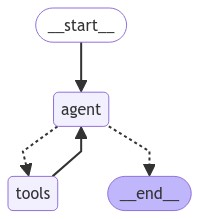

In [7]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Use it!

In [8]:
from langchain_core.messages import HumanMessage

user_to_pets.clear()  # Clear the state

print(f"User information prior to run: {user_to_pets}")

inputs = {"messages": [HumanMessage(content="my favorite pets are cats and dogs")]}
for output in app.stream(inputs, {"configurable": {"user_id": "123"}}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

print(f"User information after the run: {user_to_pets}")

User information prior to run: {}
Output from node 'agent':
---
{'messages': [AIMessage(content=[{'text': "Okay, let's update your favorite pets:", 'type': 'text'}, {'id': 'toolu_01LQK6fgtAyEo3xBfzg1fSuv', 'input': {'pets': ['cats', 'dogs']}, 'name': 'update_favorite_pets', 'type': 'tool_use'}], response_metadata={'id': 'msg_014bUFindzuzqqGmNVPX67zH', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 438, 'output_tokens': 70}}, id='run-2c77cfe0-ba1f-4cd5-922c-614330368ca3-0', tool_calls=[{'name': 'update_favorite_pets', 'args': {'pets': ['cats', 'dogs']}, 'id': 'toolu_01LQK6fgtAyEo3xBfzg1fSuv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 438, 'output_tokens': 70, 'total_tokens': 508})]}

---

Output from node 'tools':
---
{'messages': [ToolMessage(content='null', name='update_favorite_pets', tool_call_id='toolu_01LQK6fgtAyEo3xBfzg1fSuv')]}

---

Output from node 'agent':
---
{'messages': [AIMessage(content='Your f

In [9]:
print(f"User information prior to run: {user_to_pets}")


inputs = {"messages": [HumanMessage(content="what are my favorite pets?")]}
for output in app.stream(inputs, {"configurable": {"user_id": "123"}}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")


print(f"User information after the run: {user_to_pets}")

User information prior to run: {'123': ['cats', 'dogs']}
Output from node 'agent':
---
{'messages': [AIMessage(content=[{'id': 'toolu_01EsSgrDZ8aRZsg9y7ngroiu', 'input': {}, 'name': 'list_favorite_pets', 'type': 'tool_use'}], response_metadata={'id': 'msg_01Dp1VYH5RssYbReL6KzPfNM', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 437, 'output_tokens': 38}}, id='run-c620472c-ac52-488a-90f5-141fa65f1ce9-0', tool_calls=[{'name': 'list_favorite_pets', 'args': {}, 'id': 'toolu_01EsSgrDZ8aRZsg9y7ngroiu', 'type': 'tool_call'}], usage_metadata={'input_tokens': 437, 'output_tokens': 38, 'total_tokens': 475})]}

---

Output from node 'tools':
---
{'messages': [ToolMessage(content='cats, dogs', name='list_favorite_pets', tool_call_id='toolu_01EsSgrDZ8aRZsg9y7ngroiu')]}

---

Output from node 'agent':
---
{'messages': [AIMessage(content='Based on the output, your favorite pets are cats and dogs.', response_metadata={'id': 'msg_017heQcz

In [10]:
print(f"User information prior to run: {user_to_pets}")


inputs = {
    "messages": [
        HumanMessage(content="please forget what i told you about my favorite animals")
    ]
}
for output in app.stream(inputs, {"configurable": {"user_id": "123"}}):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")


print(f"User information prior to run: {user_to_pets}")

User information prior to run: {'123': ['cats', 'dogs']}
Output from node 'agent':
---
{'messages': [AIMessage(content=[{'id': 'toolu_01EcVWNpWQnoRuRtXXbndeWn', 'input': {}, 'name': 'delete_favorite_pets', 'type': 'tool_use'}], response_metadata={'id': 'msg_01PfMPkCHuV1UvcCKdqT5jXH', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'tool_use', 'stop_sequence': None, 'usage': {'input_tokens': 441, 'output_tokens': 38}}, id='run-eeac69b6-812e-4630-ba6f-9b22b672493b-0', tool_calls=[{'name': 'delete_favorite_pets', 'args': {}, 'id': 'toolu_01EcVWNpWQnoRuRtXXbndeWn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 441, 'output_tokens': 38, 'total_tokens': 479})]}

---

Output from node 'tools':
---
{'messages': [ToolMessage(content='null', name='delete_favorite_pets', tool_call_id='toolu_01EcVWNpWQnoRuRtXXbndeWn')]}

---

Output from node 'agent':
---
{'messages': [AIMessage(content='I have deleted the information about your favorite pets. The list of favorite pets has been cleared